## Writing a fieldfile for OF from a given mesh

In [90]:
import matplotlib.pyplot as plt
import numpy as np

import warnings
import os
from scipy.interpolate import griddata
from scipy import interpolate
from scipy.interpolate import interpn

import meshio
import re

In [91]:
mainfolder='airfoil2d/airFoil_400'
fields= ['U','p','nut','nuTilda']

pred_xlim =[-50,50]
pred_ylim = [-20 , 20]

main_split=mainfolder.split('/')
mainfolder_mesh=mainfolder+'/VTK/'+main_split[1]+'_0/'+'internal.vtu'

folder_pred=mainfolder+'/pred.npy'
pred=np.load(folder_pred)

[a,y_steps, x_steps,layers]=pred.shape


In [92]:
# loads the mesh and splits all relevant info into seperate variables
mesh=meshio.read(mainfolder_mesh)

cell_ptsid=mesh.cells_dict

#what happens if the mesh is not only hexahedron?
cell_ptsid=np.array(cell_ptsid['hexahedron'])

points = mesh.points

In [93]:
cell_pts=points[cell_ptsid[:,:]]

centroids=np.average(cell_pts,axis=1)

## Export to Openfoam

In [88]:
x = np.arange(pred_xlim[0],pred_xlim[1], (pred_xlim[1]-pred_xlim[0])/x_steps)
y = np.arange(pred_ylim[0],pred_ylim[1], (pred_ylim[1]-pred_ylim[0])/y_steps)

ts=20
path2folder=mainfolder+'/'+str(0)
path2dst=mainfolder+'/'+str(ts+1)

print(path2dst)
if os.path.isdir(path2dst)==False:
    os.mkdir(path2dst)

folders=os.listdir(path2dst)

airfoil2d/airFoil_400/21


airfoil2d/airFoil_400/21/U
0
1
2
(1, 10720, 3)
airfoil2d/airFoil_400/21/p
airfoil2d/airFoil_400/21/nut
airfoil2d/airFoil_400/21/nuTilda


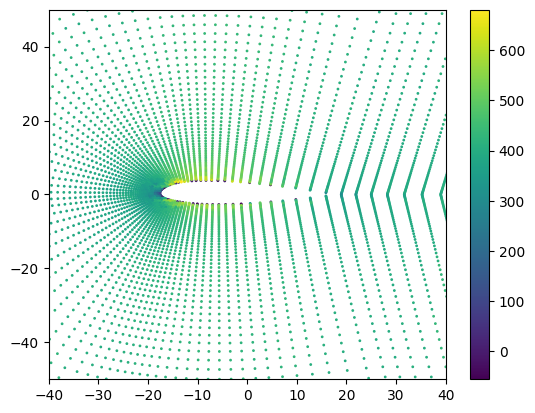

In [89]:
i=0
for field in fields:
    print(path2dst+'/'+field)
    with open(path2folder+'/'+field,"r") as f:
        contents=f.readlines()
    idx = [j for j, item in enumerate(contents) if re.search('internalField   ', item)]
    
    if field == 'U':
        U=np.empty((1,centroids.shape[0],0))
        for it in range(3):
            print(it)
            znew=[]
            znew.append( interpolate.interpn((x, y) , np.transpose(pred[:,:,:,i]), centroids[:,0:2],
                                 bounds_error=False,
                                 method='nearest',
                                 fill_value=None,
                                ))
            znew=np.array(znew)
            U=np.concatenate((U,znew),axis=2)
        print(U.shape)
        #iterates through the vertices and saves the corresponding values
        string=''
        for j in range(centroids.shape[0]):
            string = string +'('+ str(U[0,j,0]) + ' '+str(U[0,j,1])+ ' '+ str(U[0,j,2])+')''\n'
        # creates a complete list will all lines that need to be written in the field file
        contents[idx[0]]='internalField   nonuniform List<vector>'+'\n'+str(np.array(centroids).shape[0])+'\n'+'('+string+');'
        
        plt.scatter(centroids[:,0],centroids[:,1], c=U[0,:,0], s=1)
        plt.colorbar()
        plt.xlim([-40,40])
        plt.ylim([-50,50])
    else:
        znew=[]
        znew.append( interpolate.interpn((x, y) , np.transpose(pred[:,:,:,i+2]), centroids[:,0:2],
                                 bounds_error=False,
                                 method='nearest',
                                 fill_value=None,
                                ))
        znew=np.array(znew)
        
        #iterates through the vertices and saves the corresponding values
        string=''
        for j in range(centroids.shape[0]):
            string = string + str(znew[0,j,0]) + '\n'
        
        # creates a complete list will all lines that need to be written in the field file
        contents[idx[0]]='internalField   nonuniform List<scalar>'+'\n'+str(np.array(centroids).shape[0])+'\n'+'('+string+');'
        
    with open(path2dst+'/'+field,"w") as f:
        f.writelines(contents)
    i=i+1